# Common Task (Multiclass classification)

## Import required libraries

In [1]:
# Import required libraries
import torch
import torchvision
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from albumentations.pytorch import ToTensorV2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import glob
import timm
import uuid
import tqdm
from fastai.vision.all import *

## Setup Wandb to log the experiment and models

In [2]:
wandb.login()

wandb: Currently logged in as: lawjarp. Use `wandb login --relogin` to force relogin


True

## Setup Configuration

* We will be using a image size of 224,224
* We will be using efficientnet_b3
    * EfficientNet is being widely used for image classification tasks
    * It is smaller in size than ResNet18, which was one of the high performing models in the papers which we were given to refer
    * It reaches a comparable AUC score within 10 epochs of training

In [3]:
config = {
    "image_size": (224,224),
    "batch_size": 32,
    "base_model": "efficientnet_b3"
}

## Get data files

In [4]:
# Get data
# Split data into train and test
categories = {
    "no": 0,
    "sphere": 1,
    "vort": 2,
}

dataset_path = "/notebooks/gsoc-prep-23/ml4sci/data/dataset/"
train_dataset_path = dataset_path + "train/"
val_dataset_path = dataset_path + "val/"

# Get file paths as a list
train_files = glob.glob(train_dataset_path + "*/*")
val_files = glob.glob(val_dataset_path + "*/*")

print("Got files")

Got files


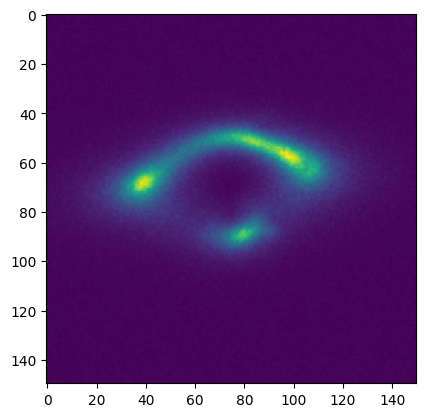

In [5]:
# Sanity check
test = np.load(train_files[0])
plt.imshow(np.transpose(test, (1,2,0)))

## Define Dataset object, augmentations and Dataloaders

In [6]:
# Dataset object
# Use albumentations for data augmentation
class SubstructureDataset(torch.utils.data.Dataset):
    def __init__(self, data_files, transform=None):
        self.data_files = data_files
        self.transform = transform
        self.totensor = torchvision.transforms.ToTensor()
    def __len__(self):
        return len(self.data_files)
    def __getitem__(self, idx):
        # open npy file
        # apply transform
        # return image and label
        image = np.load(self.data_files[idx])
        image = np.transpose(image, (1,2,0))
        label = categories[self.data_files[idx].split("/")[-2]]
        if self.transform:
            image = self.transform(image=image)["image"]
        # Convert to tensor
        image = np.transpose(image, (2,0,1))
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        image = torchvision.transforms.Resize(config['image_size'])(image)
        
        return image, label

In [7]:
# Define dataloaders
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
])

train_dataset = SubstructureDataset(train_files, transform=train_transform)
val_dataset = SubstructureDataset(val_files, transform=None)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=8)

## Define Model
* Use custom classifier to increase accuracy

In [8]:
# Define pytorch model
# Use timm for pretrained models
def create_model(model_name, num_classes):
    model = timm.create_model(model_name, pretrained=True,num_classes=num_classes, in_chans=1)
    # Check if classifier is parameter of the model
    if hasattr(model, 'fc'):
        model.fc = torch.nn.Sequential(
            torch.nn.Linear(model.fc.in_features, 1024),
            torch.nn.Dropout(0.5),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, num_classes),
        )
    return model

## Define Pytorch Lightning modules

In [9]:
# Define pl module
class SubstructureModel(pl.LightningModule):
    def __init__(self, num_classes, lr=1e-3):
        super().__init__()
        self.model = create_model(config['base_model'], num_classes=3)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.lr = lr
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

## Set up logging and Trainer 

In [10]:
# Train model
model = SubstructureModel(num_classes=3)

In [11]:
run_id = "ml4sci:"+config['base_model']+":"+str(uuid.uuid4().hex)[:3]

wandb_logger = WandbLogger(
    project="gsoc-ml4sci",
    entity="lawjarp",
    name=run_id,
    group=config['base_model'],
    log_model=True,
)
# Initialize a trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[
        RichProgressBar(leave=True),
        ModelCheckpoint(dirpath='./models/', filename=run_id, monitor="val_loss", mode="min")
    ],
    logger=wandb_logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(model, train_dataloader, val_dataloader)

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /notebooks/gsoc-prep-23/ml4sci/notebooks/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model     │ EfficientNet     │ 10.7 M │
│ 1 │ criterion │ CrossEntropyLoss │      0 │
└───┴───────────┴──────────────────┴────────┘

Trainable params: 10.7 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 10.7 M                                                                                               
Total estimated model params size (MB): 42

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


## Load best model
* Load the model with min val_loss and get AUC score

In [13]:
checkpoint = torch.load("./models/"+run_id+".ckpt")
model = create_model(config['base_model'], 3)
model_weights = checkpoint["state_dict"]
# update keys by dropping `model`
for key in list(model_weights):
    model_weights[key.replace("model.", "")] = model_weights.pop(key)
model.load_state_dict(model_weights)

<All keys matched successfully>

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve
import tqdm

# Evaluate the model on the validation set
model.eval()
model.to('cuda')
val_targets = []
val_preds = []
with torch.no_grad():
    for batch in tqdm.tqdm(val_dataloader):
        x, y = batch
        y_hat = model(x.to('cuda'))
        val_targets.extend(y.cpu().numpy())
        val_preds.extend(torch.softmax(y_hat, dim=1).cpu().numpy())

100%|██████████| 235/235 [00:12<00:00, 19.05it/s]


In [15]:
val_targets = np.array(val_targets)

In [16]:
val_auc = roc_auc_score(val_targets, val_preds, multi_class='ovr', average="macro")

print("Validation AUC score:", val_auc)


Validation AUC score: 0.9953424933333332


In [17]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss,█▇▆▃▅▃▂▂▂▂▄▃▂▅▁▁▂▂▂▃▁▂▂▂▁▁▁▂▁▁▂▁▁▁▂▁▁▁▁▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▆▄▄▃▃▂▁▁▁
epoch,9
train_loss,0.04577
trainer/global_step,9379
val_loss,0.10451
